**Programmer:** python_scripts (Abhijith Warrier)

**PYTHON SCRIPT TO *PREDICT TITANIC SURVIVAL WITH IMPROVED FEATURE ENGINEERING*. 🚢🤖📊**

This script demonstrates how to build a **Titanic Survival Prediction Model** using advanced **feature engineering** and **machine learning pipelines**.

It extracts insightful features like **Title, Family Size, Cabin Deck, Fare per Person, and Ticket Group Size**, performs **targeted imputation** for missing ages, and uses **Gradient Boosting** with cross-validation for robust performance — achieving smarter survival predictions with interpretable engineered features.

---

### **📦 Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import matplotlib.pyplot as plt

---

### **🧩 Load the Dataset**

Use your **Kaggle Titanic** If you don’t have the file handy, this cell shows the expected columns.

In [2]:
# Path to Kaggle Titanic train file (adjust as needed)
CSV_PATH = "datasets/titanic.csv"  # e.g., "/path/to/train.csv"

df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
df.head(3)

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**Expected columns:** PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked

---

### **🛠️ Feature Engineering (High-Impact Additions)**

We’ll create:

- **Title** from Name → (Mr, Mrs, Miss, Master, Rare)
- **FamilySize** = SibSp + Parch + 1
- **IsAlone** (1 if FamilySize==1)
- **TicketGroupSize** (count of same ticket)
- **CabinDeck** (first letter of Cabin, e.g., A/B/C; U if unknown)
- **FarePerPerson** = Fare / FamilySize
- **LogFare** and **AgeBin** (quantile bins)
- **Targeted Age impute** using grouped median by (Title, Sex, Pclass) as a preprocessing step

In [3]:
def extract_title(name: str) -> str:
    # Titles appear as "Lastname, Title. Firstname"
    if pd.isna(name):
        return "Unknown"
    title = name.split(",")[1].split(".")[0].strip()
    # Map rare titles
    mapping = {
        "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
        "Lady": "Rare", "Countess": "Rare", "Sir": "Rare",
        "Jonkheer": "Rare", "Don": "Rare", "Dona": "Rare",
        "Capt": "Rare", "Col": "Rare", "Major": "Rare",
        "Rev": "Rare", "Dr": "Rare"
    }
    return mapping.get(title, title)

def cabin_deck(cabin: str) -> str:
    if pd.isna(cabin) or not str(cabin).strip():
        return "U"  # Unknown
    return str(cabin)[0]

def engineer_features(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()

    # Title
    df["Title"] = df["Name"].apply(extract_title)
    # Simplify extremely rare titles
    freq = df["Title"].value_counts()
    rare_titles = freq[freq < 10].index
    df["Title"] = df["Title"].replace(dict.fromkeys(rare_titles, "Rare"))

    # Family size & solitude
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    # Ticket group size
    df["TicketGroupSize"] = df.groupby("Ticket")["Ticket"].transform("count")

    # Cabin deck
    df["CabinDeck"] = df["Cabin"].apply(cabin_deck)

    # Fare per person & log transforms (protect against zero)
    df["FarePerPerson"] = df["Fare"] / df["FamilySize"].replace(0, 1)
    df["LogFare"] = np.log1p(df["Fare"])
    df["LogFarePerPerson"] = np.log1p(df["FarePerPerson"])

    # Age bin (quantiles on available values)
    df["AgeBin"] = pd.qcut(df["Age"], q=4, duplicates="drop")

    return df

df_eng = engineer_features(df)
df_eng.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Title,FamilySize,IsAlone,TicketGroupSize,CabinDeck,FarePerPerson,LogFare,LogFarePerPerson,AgeBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,Mr,2,0,1,U,3.62500,2.110213,1.531476,"(20.125, 28.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,Mrs,2,0,1,C,35.64165,4.280593,3.601186,"(28.0, 38.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,Miss,1,1,1,U,7.92500,2.188856,2.188856,"(20.125, 28.0]"


---

### **🧼 Age Imputation by Group (Title × Sex × Pclass)**

We’ll fill **Age** using the median within (Title, Sex, Pclass) groups.

Then we’ll recompute **AgeBin** after imputation.

In [4]:
df_tmp = df_eng.copy()

age_group_median = (
    df_tmp.groupby(["Title", "Sex", "Pclass"])["Age"]
    .median()
    .reset_index()
    .rename(columns={"Age": "AgeMedian"})
)

df_tmp = df_tmp.merge(age_group_median, on=["Title", "Sex", "Pclass"], how="left")
df_tmp["Age"] = df_tmp["Age"].fillna(df_tmp["AgeMedian"])
df_tmp.drop(columns=["AgeMedian"], inplace=True)

# Recompute AgeBin with filled Age
df_tmp["AgeBin"] = pd.qcut(df_tmp["Age"], q=4, duplicates="drop")

df_eng = df_tmp
df_eng.isna().sum()

PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               687
Embarked              2
Title                 0
FamilySize            0
IsAlone               0
TicketGroupSize       0
CabinDeck             0
FarePerPerson         0
LogFare               0
LogFarePerPerson      0
AgeBin                0
dtype: int64

---

### **🧾 Select Features & Train/Test Split**

In [5]:
TARGET = "Survived"

features = [
    # Numeric
    "Age", "Fare", "FamilySize", "IsAlone", "TicketGroupSize",
    "FarePerPerson", "LogFare", "LogFarePerPerson",
    # Categorical
    "Pclass", "Sex", "Embarked", "Title", "CabinDeck", "AgeBin"
]

X = df_eng[features]
y = df_eng[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

---

### **🏗️ Preprocessing Pipeline**

- **Numeric** → impute median → scale
- **Categorical** → impute most frequent → one-hot

In [6]:
numeric_features = ["Age", "Fare", "FamilySize", "IsAlone", "TicketGroupSize", "FarePerPerson", "LogFare", "LogFarePerPerson"]
categorical_features = ["Pclass", "Sex", "Embarked", "Title", "CabinDeck", "AgeBin"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

---

### **🤖 Train Strong Baselines (LogReg / GBDT / RF)**

We’ll evaluate **ROC AUC** with stratified CV and then fit final models.

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=5000, C=1.0, class_weight=None, n_jobs=None if hasattr(LogisticRegression, "n_jobs") else None),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42)
}

cv_scores = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=cv)
    cv_scores[name] = (scores.mean(), scores.std())
    print(f"{name}: ROC AUC {scores.mean():.3f} ± {scores.std():.3f}")

# Pick one strong model for final fit (GBDT is often great here)
final_model = Pipeline(steps=[("prep", preprocessor), ("clf", GradientBoostingClassifier(random_state=42))])
final_model.fit(X_train, y_train)

LogisticRegression: ROC AUC 0.871 ± 0.025
GradientBoosting: ROC AUC 0.897 ± 0.023
RandomForest: ROC AUC 0.882 ± 0.016


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


---

### **📊 Evaluate on Test Set**

Test ROC AUC: 0.8505928853754942

Classification Report:
               precision    recall  f1-score   support

           0      0.829     0.836     0.833       110
           1      0.735     0.725     0.730        69

    accuracy                          0.793       179
   macro avg      0.782     0.781     0.781       179
weighted avg      0.793     0.793     0.793       179



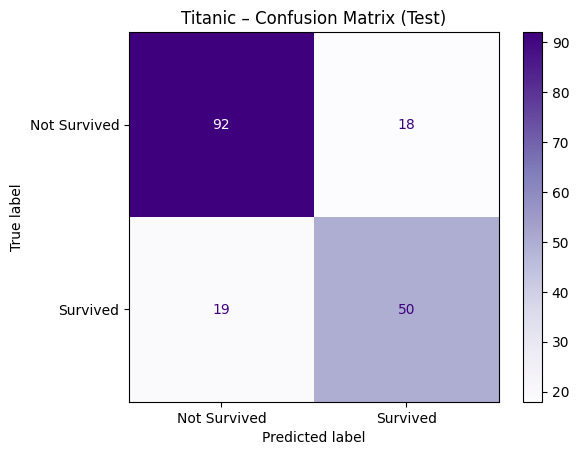

In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Survived", "Survived"])
disp.plot(cmap="Purples")
plt.title("Titanic – Confusion Matrix (Test)")
plt.show()

---

### **🔎 Quick Hyperparameter Tune (GBDT)**

In [9]:
param_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__max_depth": [2, 3],
    "clf__subsample": [0.8, 1.0]
}

gbdt = Pipeline(steps=[("prep", preprocessor), ("clf", GradientBoostingClassifier(random_state=42))])
grid = GridSearchCV(gbdt, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)

best_model = grid.best_estimator_
y_proba_best = best_model.predict_proba(X_test)[:, 1]
print("Test AUC (best):", roc_auc_score(y_test, y_proba_best))

Best AUC: 0.9049128167780205
Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
Test AUC (best): 0.8478919631093546


---

### **📤 Predict for Submission (Optional Kaggle Step)**

In [10]:
# If you want to create a Kaggle submission:
# Load test.csv, apply the SAME feature engineering, then predict.

TEST_CSV_PATH = "datasets/titanic.csv"  # adjust if needed
test_df = pd.read_csv(TEST_CSV_PATH)

test_eng = engineer_features(test_df)

# Impute Age via the same grouped median strategy (fit on TRAIN!)
age_group_median_train = (
    df_eng.groupby(["Title", "Sex", "Pclass"])["Age"]
    .median()
    .reset_index()
    .rename(columns={"Age": "AgeMedian"})
)

test_eng = test_eng.merge(age_group_median_train, on=["Title", "Sex", "Pclass"], how="left")
test_eng["Age"] = test_eng["Age"].fillna(test_eng["AgeMedian"])
test_eng.drop(columns=["AgeMedian"], inplace=True)
test_eng["AgeBin"] = pd.qcut(test_eng["Age"], q=4, duplicates="drop")

X_submit = test_eng[features]
pred_submit = best_model.predict(X_submit) if 'best_model' in globals() else final_model.predict(X_submit)

submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": pred_submit.astype(int)
})
submission.head()
# submission.to_csv("submission.csv", index=False)

,PassengerId,Survived
0,1,0
1,2,1
2,3,0
3,4,1
4,5,0


---